title: Genetic Optimization for Sales Forecasting
description: Deep, Feed Forward Neural networks were implemented to forecast on the basis of lags of the sales series. Moreover, Genetic Optimization was used to choose the optimal architecture for each predictive model.

# Development of Genetic Artificial Intelligence Forecast for BI case
**Author:** Juan Guillermo Osío Jaramillo

**Role:** Freelance consultant and developer on Machine Learning, Artificial Intelligente and Genetic Optimization

<br>

<a id='introduction'></a>
## Introduction
---
This project was about the development of an AI based, *high performance* **forecasting system** for a *Business Intelligence* use case, the main goal being producing 1-month ahead forecast of *total sales* for a *food delivery application*. Data was fetched from a private *data warehouse* in a mostly structured format and, so that the heavy load of the *development effort* was at the **model development** and **calibration** stages of the *ML workflow*. *Deep, Feed Forward Neural networks* were implemented to forecast on the basis of lags of the sales series. Moreover, **Genetic Optimization** was used to choose the optimal architecture for each predictive model.

<a id='business-setting'></a>
## Business setting
---

 The company of interest is a supper-app which provides intermediation between restaurants/grocery stores and their customers. The company adds value by platforming and coordinating actions on the delivery pipeline such as order creation, payment confirmation, courier matching, order tracking, and delivery confirmation. By 2020, the company has experienced financial and commercial success after 5 years of operation. It is one of the major players in a Colombian city and holds partnerships with a network of over 200 M business and with over 250 M independent couriers. Being a brand with large market penetration, it has become the <i>de-facto</i> standard for ordering food for household consumption.

For the sake of this exercise, let's consider the overall system load organically created by their user base at each moment in time as a single warehouse system. Admittedly, this is only a <i>simplified model</i>  for a <i>decentralized</i> producer-consumer system, as items are never warehoused in the same physical location. There is the opportunity to pick up some <i>business intelligence</i> by means of a <i>forecasting system</i> which labels dates where high demand is expected according to historical patterns. This system can be used by the company personnel to ensure that different teams are well prepared to <i>scale up</i> the operation in moments of peak demand, so that the whole potential revenue is fulfilled by the company. Segmentation and classification can be easily performed on the basis of accurate forecast, and therefore we recast the goal as a problem of developing a high-performance forcasting system.


<br>

<a id='table-of-contents'></a>
## Table of Contents
---

As this report is served as an online notebook, I will host all the code without giving a full modular structure. Yet the following table of contents glimpses the overall architecture.

<br>

0. [Application set up](#set-up)

**PART 1 - Forecasting system with Artificial intelligence**

1. [Serving ML samples from BI data](#ml-samples)
2. [Time Series Featurizer](#featurizer)
3. [Deep-Neural-Network for regression](#dnn-model)
4. [Training pipeline](#training-pipeline)
5. [Forecasting sales](#forecasting)

**PART 2 - Calibration system with Genetic Optimization**


<br>

<a id='set-up'></a>
## Aplication set up
---

In [ ]:
#
# 0.0 set-up  libraries
#
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install psutil
import psutil
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#
# 0.1 set-up a cloud (drive based) filesystem
#

os.chdir(os.path.join('drive','MyDrive', 'professional portfolio','genetic_optimization'))
os.listdir()

['dev_dataset.csv', 'etl_sink', 'genetic_optimization.ipynb']

In [ ]:
#
# 0.2 main configuration of the forecasting exercie
#

SPLIT_RATIO=0.5
FORECAST_HORIZON=24*7*2

<br>

<a id='ml-samples'></a>
## 1. Inspecting BI data
---

For this exercise, we will use time series data for the orders received through the company’s app. The raw dataset contains event-level records fetched from the company’s private data warehouse. The records list various features of the orders, but we will only utilize the unique order identifier and the timestamp when each order was accepted into the system. We counted the number of unique records created in high-frequency (15 minutes) and low-frequency (1 hour) bins, thus creating a couple of time series datasets for order counts over a subset of the available historical data. For this exercise, we will focus solely on the low-frequency dataset, as our emphasis is on building long-term capacity planning. The implementation of this ETL is off the scopt of this notebook and therefore will not be displayed.

In [ ]:
import os
import pandas as pd
os.listdir("etl_sink")

['43891.csv', '98065.csv', '20150.csv', '37517.csv', 'metadata.json']

In [ ]:
df=pd.read_csv('etl_sink/20150.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2208 entries, 0 to 2207
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   datetime      2208 non-null   object
 1   value         2208 non-null   int64 
 2   quarter_year  2208 non-null   object
dtypes: int64(1), object(2)
memory usage: 51.9+ KB


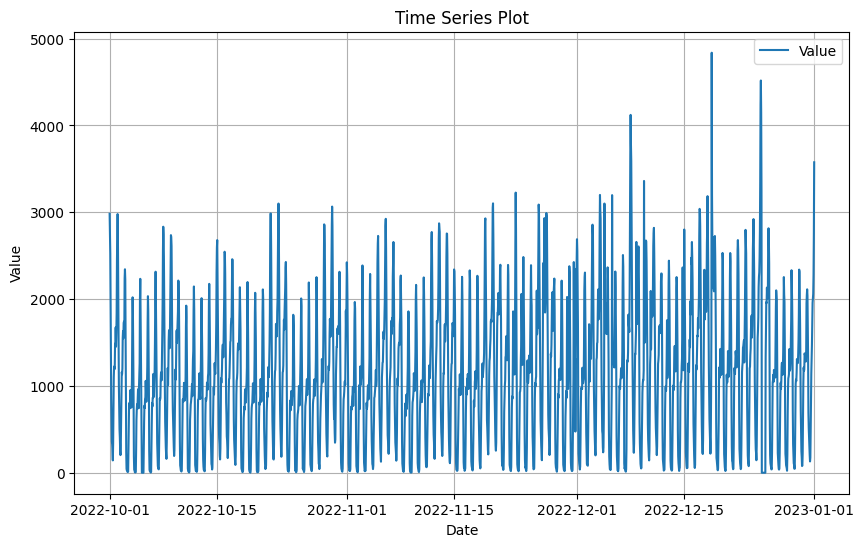

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data (replace with your actual DataFrame)
# df = pd.read_csv('your_data.csv')  # If loading from a file

# Step 1: Ensure 'datetime' is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Step 2: Set 'datetime' as index for the plot without dropping it
df_for_plot = df.set_index('datetime', drop=False)

# Step 3: Plot the 'value' column over time
plt.figure(figsize=(10, 6))
plt.plot(df_for_plot.index, df_for_plot['value'], label='Value')

# Customizing the plot
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

# Step 4: Show the plot
plt.show()

In [ ]:
df['datetime'].describe()

count                             2208
mean     2022-11-15 23:30:59.999999744
min                2022-10-01 00:01:00
25%                2022-10-23 23:46:00
50%                2022-11-15 23:31:00
75%                2022-12-08 23:16:00
max                2022-12-31 23:01:00
Name: datetime, dtype: object

<br>

<a id='ml-samples'></a>
## 2. Serving ML samples from BI data
---

In supervised machine learning, we transform historical data into arrays of input-output pairs for training and testing. In the context of time series data, feature selection requires special consideration because the historical behavior of a variable is often useful for predicting its future behavior. To address this, we create lagged versions of the same variable as features while using the variable itself as the target. However, any lags within the forecast horizon are excluded to ensure that only information available up to the prediction point is used in a real-world production environment.

The class PrepareTsDataForForecasting is responsible for generating the train and test samples from time series data. It is initialized with a dataset_folder that contains a set of time series datasets and metadata. When calling load_data_from_event_code for a dataset, the class performs data integrity checks and analyzes the data's frequency. It then calculates the number of periods that match the forecast horizon (forecast_horizon_in_intrinsic_scale) to ensure the forecast horizon in days is met. The get_train_data and get_test_data methods create the necessary lagged features and return the training and testing samples..

In [ ]:
import os
import pandas as pd
import numpy as np
import json

try:
    import plotly
except ImportError:
    os.system("pip install plotly")
    import plotly

import plotly.graph_objects as go
import plotly.express as px
from sklearn.linear_model import LinearRegression


In [ ]:
class Prepare_ts_data_for_forecasting:

    # Constants
    DEFAULT_START_DATE = '2010-01-01'
    DEFAULT_END_DATE = '2019-12-31'
    DEFAULT_TEST_PERCENTAGE = 0.5
    DEFAULT_DATASET_INFO = "Not provided for this dataset"
    DEFAULT_TIME_SERIES_LABEL = "Time Series"
    PROBLEM_TYPE = "forecasting"

    # Initialization
    def __init__(self,
                 dataset_folder,
                 start_date=None,
                 end_date=None,
                 test_percentage=None,
                 dataset_info="No summary info provided for this dataset",
                 dataset_title="No title provided for this dataset",
                 forecast_horizon_in_days=30,
                 backsight_in_days=None):

        self.dataset_folder = os.path.join(dataset_folder)  # Pointing to the 'transformed' subfolder
        self.metadata = self._load_metadata()  # Load other metadata keys as instance variables

        self.metadata["title"] = dataset_title

        self.data = None
        self.start_date = start_date if start_date is not None else self.DEFAULT_START_DATE
        self.end_date = end_date if end_date is not None else self.DEFAULT_END_DATE
        self.test_percentage = test_percentage if test_percentage is not None else self.DEFAULT_TEST_PERCENTAGE

        self.dataset_title = dataset_title
        self.dataset_info = dataset_info if dataset_info is not None else self.DEFAULT_DATASET_INFO
        self.time_series_label = self.DEFAULT_TIME_SERIES_LABEL
        self.available_event_codes = self._list_available_event_codes()


        self.forecast_horizon_in_days = forecast_horizon_in_days
        self.forecast_horizon_in_intrinsec_scale = None
        self.backsight_in_days = backsight_in_days
        self.backsight_in_intrinsec_scale = None

        self.baseline_model = None
        self.train_sample = None
        self.predictive_model = None

    #
    def _load_metadata(self):
        metadata_path = os.path.join(self.dataset_folder, 'metadata.json')
        if not os.path.exists(metadata_path):
            raise FileNotFoundError(f"Metadata file not found at: {metadata_path}")
        with open(metadata_path, 'r') as f:
            return json.load(f)
    #
    def _list_available_event_codes(self):
        metadata = self.metadata
        codes_to_labels = metadata.get('codes_to_labels', {})

        if not codes_to_labels:
            raise ValueError("No 'codes_to_labels' found in metadata.")

        # Invert the dictionary to map labels to codes
        return {label: code for code, label in codes_to_labels.items()}


    #
    # loading time series data from disk
    #

    #
    def load_data_from_event_code(self, event_code):
        matching_files = [file for file in os.listdir(self.dataset_folder) if event_code in file and file.endswith('.csv')]
        if not matching_files:
            raise ValueError(f"No CSV files found matching event code: {event_code}")

        try:
            dfs = []
            for file in matching_files:
                file_path = os.path.join(self.dataset_folder, file)
                df = pd.read_csv(file_path)
                date_column = 'date' if 'date' in df.columns else 'datetime' if 'datetime' in df.columns else None
                if date_column is None:
                    raise ValueError(f"CSV file '{file}' does not contain 'date' or 'datetime' columns.")
                df[date_column] = pd.to_datetime(df[date_column])
                dfs.append(df.set_index(date_column))

            self.data = pd.concat(dfs, ignore_index=False).sort_index()
            self.data.dropna(inplace=True)

            self.time_series_label = next((key for key, value in self.available_event_codes.items() if value == event_code), self.DEFAULT_TIME_SERIES_LABEL)

            self.date_col = self._detect_date_col(allowed_date_col_names=None)
            self.frequency = self._detect_frequency()  # Detect frequency after setting date_col

            # Use initialized forecast horizon
            self.forecast_horizon_in_intrinsec_scale = self.convert_days_to_frequency_units(self.forecast_horizon_in_days)

            # Compute or use initialized backsight
            if self.backsight_in_days is None:
                self.backsight_in_days = self._compute_backsight_in_days()  # Call the heuristic method
            self.backsight_in_intrinsec_scale = self.convert_days_to_frequency_units(self.backsight_in_days)

        except Exception as e:
            raise ValueError(f"Error during loading process: {str(e)}")
    #
    def _detect_date_col(self, allowed_date_col_names):
        if allowed_date_col_names is None:
            allowed_date_col_names = ['date', 'datetime']  # Default values
        for file in os.listdir(self.dataset_folder):
            if file.endswith('.csv'):
                file_path = os.path.join(self.dataset_folder, file)
                try:
                    df = pd.read_csv(file_path, nrows=1)  # Read only the first row for efficiency
                    for col in allowed_date_col_names:
                        if col in df.columns:
                            return col
                except Exception as e:
                    raise ValueError(f"Error reading '{file}' with exception: {e}")
        raise ValueError("No appropriate date column found")

    #
    def get_forecast_parameters(self):
        # Check if the necessary attributes are set
        if self.frequency is None or self.forecast_horizon_in_days is None or \
        self.forecast_horizon_in_intrinsec_scale is None or \
        self.backsight_in_days is None or self.backsight_in_intrinsec_scale is None:
            return {"error": "Forecast parameters are not set. Please load the data first."}

        # Construct the dictionary with parameters
        forecast_params = {
            "frequency": self.frequency,
            "forecast_horizon_in_days": self.forecast_horizon_in_days,
            "forecast_horizon_in_intrinsec_scale": self.forecast_horizon_in_intrinsec_scale,
            "backsight_in_days": self.backsight_in_days,
            "backsight_in_intrinsec_scale": self.backsight_in_intrinsec_scale
        }
        #
        return forecast_params

    def _detect_frequency(self):
        if self.data is None or self.date_col is None:
            raise ValueError("Data has not been loaded or date column has not been set")
        if not self.data.index.is_monotonic_increasing:
            raise ValueError("Index is not set to a datetime or is not sorted")
        return self.data.index.to_series().diff().value_counts().idxmax()
    #
    def convert_days_to_frequency_units(self, days):
        """
        Convert days to the equivalent number of frequency units based on self.frequency.
        """
        if self.frequency is None:
            raise ValueError("Frequency has not been detected. Load data and set frequency before converting days.")
        # Assuming self.frequency is a Pandas Timedelta object or similar
        return int(round((pd.to_timedelta(days, unit='D') / self.frequency)))
    #
    def _compute_backsight_in_days(self):
        if self.frequency is None:
            raise ValueError("Frequency has not been detected.")

        # Convert frequency to a total number of seconds for comparison
        freq_in_seconds = self.frequency.total_seconds()

        # Intra-hour data (less than 3600 seconds)
        if freq_in_seconds < 3600:
            return 7  # 7 days
        # Up to daily data (3600 seconds to 86400 seconds)
        elif freq_in_seconds <= 86400:
            return 10  # 15 days
        # Up to monthly data (more than a day but less than or equal to 30 days)
        elif freq_in_seconds <= 2592000:
            return 60  # 60 days
        # Monthly data or slower (more than 30 days)
        else:
            return 365  # 365 days


    def define_testing_policy(self, start_date=None, end_date=None, test_percentage=None):
        if self.data is None:
            raise ValueError("Data not loaded. Load data before defining a testing policy.")

        # Use method parameters if provided, otherwise use instance attributes
        start_date = pd.Timestamp(start_date if start_date is not None else self.start_date)
        end_date = pd.Timestamp(end_date if end_date is not None else self.end_date)
        test_percentage = test_percentage if test_percentage is not None else self.test_percentage

        df = self.data[(self.data.index >= start_date) & (self.data.index <= end_date)]
        num_test_samples = int(len(df) * test_percentage)

        df['sample'] = 'train'
        df.loc[df.tail(num_test_samples).index, 'sample'] = 'test'
        self.data = df
        return self.data['sample'].value_counts()

    def make_samples(self, sample_type='train', output_sequence=False, value_col='value'):
        if self.data is None:
            raise ValueError("Data has not been loaded.")
        if self.date_col is None:
            raise ValueError("Date column has not been set.")
        if self.frequency is None:
            raise ValueError("Frequency has not been detected.")

        if sample_type == 'train':
            data_sample = self.data[self.data['sample'] != 'test']
        elif sample_type == 'test':
            data_sample = self.data[self.data['sample'] == 'test']
        else:
            raise ValueError("sample_type must be either 'train' or 'test'.")

        back_sight = self.convert_days_to_frequency_units(self.backsight_in_days)
        fore_sight = self.convert_days_to_frequency_units(self.forecast_horizon_in_days)

        X, y = [], []

        if sample_type == 'train':
            for i in range(back_sight, len(data_sample) - fore_sight):
                X.append(data_sample.iloc[i - back_sight:i][value_col].values)
                if output_sequence:
                    y.append(data_sample.iloc[i:i + fore_sight][value_col].values)
                else:
                    y.append(data_sample.iloc[i + fore_sight - 1][value_col])
        elif sample_type == 'test':
            #
            start_index = len(self.data) - len(data_sample) - fore_sight
            end_index = len(self.data) - fore_sight
            #
            for i in range(start_index, end_index):
                X.append(self.data.iloc[i - back_sight:i][value_col ].values)
                if output_sequence:
                    y.append(self.data.iloc[i:i + fore_sight][value_col ].values)
                else:
                    y.append(self.data.iloc[i + fore_sight][value_col])  # No .values needed here

        X, y = np.array(X), np.array(y)
        return X, y
    #
    def get_train_data(self, **kwargs):
        return self.make_samples(sample_type='train', **kwargs)
    #
    def get_test_data(self, **kwargs):
        return self.make_samples(sample_type='test', **kwargs)


    #
    @staticmethod
    def apply_plot_styling(fig):
        """
        Apply consistent styling to a plotly figure.
        """
        fig.update_layout(
            margin=dict(t=30, l=30, r=30, b=30),  # Margins
            legend=dict(x=0.75, y=1, bgcolor='rgba(255, 255, 255, 0.5)')  # Legend
        )
        return fig

    #
    def plot(self, preds=None):
        """
        This methods is responsible for the plots of historical and forecasted values shown to end-users, wether in a server or UX access
        """
        #
        # (0.1) data need to be loaded to perform a plot
        #
        if self.data is None or self.data.empty:
            raise ValueError("No data to plot. Load data first.")
        #
        # (0.2) data needs to be indexed, and assigned to an experimental case
        #
        if 'sample' not in self.data.columns or 'value' not in self.data.columns:
            raise ValueError("Data does not contain required columns 'sample' and 'value'.")

        train_data = self.data[self.data['sample'] == 'train']
        test_data = self.data[self.data['sample'] == 'test']


        # Setting the dynamic title
        if preds is None:
            title = f"Historical values and sample split for time series '{self.time_series_label}'"
        else:
            title = f"Historical values, sample split, and optimal forecasts for time series '{self.time_series_label}'"
        #
        # Forecast line
        forecast_label = "Naive Forecast" if preds is None else "Forecast"


        # Use base_forecast with lagged_rolling_window method if no predictions are provided
        if preds is None:
            preds = self.base_forecast(method='lagged_rolling_window', back_sight_days=28*5, lag_days=30)

        # The rest of your existing plot method code goes here
        fig = go.Figure()


        # Default style
        for dataset, color, name in [(train_data, 'blue', 'Train'), (test_data, 'red', 'Test')]:
            # Line trace
            fig.add_trace(go.Scatter(
                x=dataset.index,
                y=dataset['value'],
                mode='lines',
                name=name,
                line=dict(shape='linear', color=color, width=1.4),
                opacity=0.7  # Set opacity for line
            ))

            # Marker trace
            fig.add_trace(go.Scatter(
                x=dataset.index,
                y=dataset['value'],
                mode='markers',
                name=name,
                marker=dict(color=color, size=7 * 1.5, opacity=0.15),  # 1.5 times bigger and 50% opacity for markers
                showlegend=False  # Prevent duplicate legend entries
            ))


        fig.add_trace(go.Scatter(
            x=test_data.index,
            y=preds,
            mode='lines',
            name=forecast_label,
            line=dict(color='green', width=3.0, dash='dash'),
            #opacity=1  # Set opacity for line
        ))

        fig.update_layout(title=title)
        # Apply consistent styling (assuming this is a method in your class)
        fig = Prepare_ts_data_for_forecasting.apply_plot_styling(fig)
        fig.show()
        return fig
    #
    def base_forecast(self,
                      method='average_train',
                      back_sight_days=60,
                      lag_days=30
                      ):
        """
        Generates forecasts using different methods.
        'average_train' replicates the average of training data.
        'lagged_rolling_window' uses a rolling window on the lagged series.

        Parameters:
        - method: The forecasting method to use ('average_train' or 'lagged_rolling_window').
        - back_sight_days: Number of days for the rolling window.
        - lag_days: Number of days to lag the series.
        """
        if self.data is None or 'sample' not in self.data.columns or 'value' not in self.data.columns:
            raise ValueError("Data not loaded or required columns are missing.")

        if method == 'average_train':
            train_data = self.data[self.data['sample'] == 'train']
            average_train = np.mean(train_data['value'])
            test_data = self.data[self.data['sample'] == 'test']
            return np.full(len(test_data), average_train)

        elif method == 'lagged_rolling_window':
            # Ensure frequency is set
            if self.frequency is None:
                raise ValueError("Frequency has not been detected. Load data and set frequency before forecasting.")

            # Convert days to frequency units and ensure they are integers
            back_sight = self.convert_days_to_frequency_units(back_sight_days)
            lag = self.convert_days_to_frequency_units(lag_days)

            if back_sight is None or lag is None:
                raise ValueError("Error in converting days to frequency units.")

            # Ensure the values are integers
            back_sight = int(back_sight)
            lag = int(lag)

            # Apply rolling window on the lagged series
            rolled_series = self.data['value'].shift(lag).rolling(window=back_sight).mean()

            # Extract the forecast for the test period
            test_data = self.data[self.data['sample'] == 'test']
            return rolled_series.loc[test_data.index].fillna(method='bfill').values

        else:
            raise ValueError(f"Unknown forecasting method: {method}")

    #
    # 0.
    #
    @classmethod
    def validate_etl(cls, dataset_folder):

        transformed_path = os.path.join(dataset_folder, 'transformed')
        metadata_path = os.path.join(transformed_path, 'metadata.json')

        if not os.path.isfile(metadata_path):
            print(f"Validation failed: 'metadata.json' not found in {dataset_folder}")
            return False

        try:
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
                if not isinstance(metadata, dict) or not all(isinstance(key, str) for key in metadata):
                    print("Validation failed: 'metadata.json' format is incorrect")
                    return False
        except json.JSONDecodeError:
            print("Validation failed: 'metadata.json' is not valid JSON")
            return False

        csv_files = [f for f in os.listdir( transformed_path) if f.endswith('.csv')]
        if not csv_files:
            print("Validation failed: No CSV files found in the dataset folder.")
            return False

        for file_name in csv_files:
            file_path = os.path.join( transformed_path, file_name)
            try:
                df = pd.read_csv(file_path)
                date_column = 'date' if 'date' in df.columns else 'datetime' if 'datetime' in df.columns else None
                if date_column is None:
                    print(f"Validation failed: CSV file '{file_name}' does not contain 'date' or 'datetime' columns.")
                    return False
            except Exception as e:
                print(f"Validation failed: Error reading '{file_name}' with exception: {e}")
                return False

        print("ETL Validation Passed.")
        return True


In [ ]:
import os
import platform
import sys

#
# 1.3 data manager for the food-sales time series collection
#
warehouse_demand_ts_collection = Prepare_ts_data_for_forecasting(
    dataset_folder=os.path.join(
        "etl_sink"
        ),
    start_date='2022-01-01',
    end_date='2022-12-31'
    )

In [ ]:
warehouse_demand_ts_collection.metadata

{'codes_to_labels': {'43891': 'Q1-2022',
  '37517': 'Q2-2022',
  '98065': 'Q3-2022',
  '20150': 'Q4-2022'},
 'dataset_summary': '\n    This is a collection of effective demand (sales) for a well-positioned warehouse system which ships goods and services to customers in multiple cities.  The target of interest will be the sales series summed-up at hourly, weekly and daily-levels over subperiods of 2020. To protect the privacy of the data, an index is derived by resampling the raw sales data and rescaling to the unitary interval. An appealing feature of this data is keeping the statical properties of an e-commerce system such as clear stational patterns and holiday-driven peaks in consumption.\n    ',
 'etl_run_timestamp': None,
 'title': 'No title provided for this dataset'}

In [ ]:
warehouse_demand_ts_collection.load_data_from_event_code('43891')

In [ ]:
warehouse_demand_ts_collection.get_forecast_parameters()

{'frequency': Timedelta('0 days 01:00:00'),
 'forecast_horizon_in_days': 30,
 'forecast_horizon_in_intrinsec_scale': 720,
 'backsight_in_days': 10,
 'backsight_in_intrinsec_scale': 240}

In [ ]:
warehouse_demand_ts_collection.define_testing_policy(test_percentage=.5)
warehouse_demand_ts_collection.plot()

<ipython-input-36-433e1bff3e10>:376: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [ ]:
train_data_shapes = [np.shape(_) for _ in warehouse_demand_ts_collection.get_train_data()]
test_data_shapes = [np.shape(_) for _ in warehouse_demand_ts_collection.get_test_data()]

# Assuming train and test data have the same structure
data_labels = ["Input Features", "Target Series", "Time Steps"]

# Print dimensions for train data
print("Train Data Dimensions:")
for i, shape in enumerate(train_data_shapes):
    print(f"{data_labels[i]}: {shape}")

# Print dimensions for test data
print("\nTest Data Dimensions:")
for i, shape in enumerate(test_data_shapes):
    print(f"{data_labels[i]}: {shape}")


Train Data Dimensions:
Input Features: (120, 240)
Target Series: (120,)

Test Data Dimensions:
Input Features: (1080, 240)
Target Series: (1080,)


<br>

<a id='genetic-optimization'></a>
## 3. Genetic Optimization
---

InIn this section, I will implement a module that utilizes Genetic Optimization to discover competitive configurations for a forecasting system designed for BI time series data. The core of this system is the ability to launch optimization jobs to find the optimal set of hyperparameters for a machine learning model, which will be implemented later. The logic is developed in a model-agnostic manner, allowing the algorithm to be used for hyperparameter tuning of any predictive model chosen during the development process.

This module will be useful as long as there is a configurable training environment for a machine learning or AI predictive algorithm. For example, in the case of a two-layer neural network, the optimization can target decision variables such as the number of neurons in each intermediate layer, activation functions, dropout rates, and other parameters.

Developing a productive Genetic Optimization system can indeed be very challenging. I will serve the module in 4 steps trough an *inheritance pattern*: i.e. functionality will be added incrementally to the core class until the complete service is fully implemented in the more specialized subclass.


In [ ]:
import time
import random
import pandas as pd
import numpy as np
import json
import os
import logging
from abc import ABC, abstractmethod
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Border, Side

# Ensure necessary packages are installed
import os

try:
    import matplotlib
except ImportError:
    os.system("pip install matplotlib")
    import matplotlib

try:
    import sklearn
except ImportError:
    os.system("pip install scikit-learn")
    import sklearn

try:
    import optree
except ImportError:
    os.system("pip install optree")
    import optree

try:
    import tensorflow
except ImportError:
    os.system("pip install tensorflow")
    import tensorflow


<br>

<a id='abstract-evolutionary-algorithm'></a>
## 3.1 Abstract Evolutionary Algorithm
---

The code sample below defines a generic class that provides an abstraction for an Evolutionary Algorithm. This class serves as a blueprint or implementation guide, outlining all the abstract methods required for a complete evolutionary algorithm, though it does not yet implement the key steps.

In an Evolutionary Algorithm, an N-sized population of candidate solutions evolves over G generations. Selective pressure is applied across multiple rounds using a fitness-driven survival probability, where the fittest solutions are more likely to pass their genes to the next generation.

The initial population is generated randomly from the feasible space at the time of instantiation. The main entry point of the system is the evolve method, which iterates the evolution process until a termination criterion is met. Each iteration replaces the current population with a new generation by combining the better solutions. This involves several key steps, such as selection, crossover, and mutation, to generate offspring. In this blueprint, these core routines are defined as abstract methods that need to be implemented by the developer.

In [ ]:
#
class EvolutionaryAlgorithm(ABC):
    """
    Defines key instance variables and abstract instance methods as needed to perform an EA for some optimization problem.
    """

    def __init__(self,
                 population_size=25,
                 mutation_rate=0.02,
                 crossover_rate=0.8,
                 exceptionalism_rate=0.05,
                 **kwargs
                 ):

        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.exceptionalism_rate = exceptionalism_rate
        self.population = self.initialize_population()
        self.fitness = []

    @abstractmethod
    def initialize_population(self) -> list:
        """
        Must return a list of dictionaries, each dictionary represents an individual.
        """
        pass

    #
    @abstractmethod
    def _compute_fitness(self):
        """
        Compute the fitness of all individuals in the current population.
        This could store the results in an internal data structure or as an attribute of the individuals.
        """
        pass
    #
    @abstractmethod
    def select_parents(self) -> tuple:
        """
        Select two parents for reproduction and return them as a tuple.
        """
        pass

    #
    @abstractmethod
    def crossover(self, parent1: dict, parent2: dict) -> tuple:
        """
        Perform crossover and return two offspring as a tuple of dictionaries.
        """
        pass

    #
    @abstractmethod
    def mutate(self, offspring: dict) -> dict:
        """
        Apply mutation to an offspring and return the mutated individual.
        """
        pass

    #
    def replace_population(self, new_population: list):
      self.population = new_population

    #
    def evolve(self):
        while not self._termination_criterion():

            # Compute fitness of all individuals
            self._compute_fitness()

            new_population = []

            while len(new_population) < len(self.population):
                parent1, parent2 = self.select_parents()

                if random.random() < self.crossover_rate:
                    offspring1, offspring2 = self.crossover(parent1, parent2)
                else:
                    offspring1, offspring2 = parent1, parent2

                if random.random() < self.mutation_rate:
                    offspring1 = self.mutate(offspring1)
                    offspring2 = self.mutate(offspring2)

                new_population.extend([offspring1, offspring2])

            self.replace_population(new_population[:len(self.population)])
    #
    @abstractmethod
    def _termination_criterion(self) -> bool:
        """
        Determines whether the evolutionary algorithm should terminate.
        Return True if termination criteria are met, False otherwise.
        """
        pass

<br>

<a id='vanilla-evolutionary-algorithm'></a>
## 3.2 Vanilla Evolutionary Algorithm
---

In [ ]:
import numpy as np
import logging
import json
import random
import time
from abc import abstractmethod

# Initialize the logging configuration
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

class VanillaModelConfOptimizer(EvolutionaryAlgorithm):

    def __init__(self, feasible_params, data_assembler=None, train_X=None, train_Y=None, test_X=None, test_Y=None, **kwargs):
        self.forecast_parameters = self._init_forecast_parameters(data_assembler)
        self.feasible_space = self._init_feasible_space(feasible_params)
        self.feasible_space_types = self._determine_param_types(self.feasible_space)
        self.train_X, self.train_Y, self.test_X, self.test_Y = self._init_data(data_assembler, train_X, train_Y, test_X, test_Y)
        self.data_assembler = data_assembler
        self.best_individual = None
        self.max_fitness = float('-inf')
        self.fitness_cache = {}
        self.evaluation_counter = 0
        self.total_individuals_to_evaluate=None
        super().__init__(**kwargs)
        logger.info("[INFO] Initialization complete.")

    def _init_forecast_parameters(self, data_assembler):
        if hasattr(data_assembler, 'get_forecast_parameters'):
            forecast_parameters = data_assembler.get_forecast_parameters()
            logger.debug("[DEBUG] Forecast parameters obtained from data assembler.")
        else:
            forecast_parameters = None
            logger.warning("[WARN] 'get_forecast_parameters' method is not available in 'data_assembler'. Defaulting to None.")
        return forecast_parameters

    def _init_feasible_space(self, feasible_params):
        feasible_space = {}
        for key, values in feasible_params.items():
            if isinstance(values[0], (int, float)):
                feasible_space[key] = (min(values), max(values))
            else:
                feasible_space[key] = values
        logger.debug("[DEBUG] Feasible space initialized.")
        return feasible_space

    def _determine_param_types(self, feasible_space):
        param_types = {}
        for key, space in feasible_space.items():
            if isinstance(space, tuple) and len(space) == 2:
                param_types[key] = "continuous"
            elif isinstance(space, list) or all(isinstance(x, str) for x in space):
                param_types[key] = "discrete"
            else:
                raise ValueError(f"Invalid space for parameter '{key}': {space}")
        logger.debug("[DEBUG] Parameter types determined.")
        return param_types

    def _init_data(self, data_assembler, train_X=None, train_Y=None, test_X=None, test_Y=None):
        self.data_assembler = data_assembler
        if self.data_assembler is not None:
            if hasattr(self.data_assembler, 'get_train_data') and hasattr(self.data_assembler, 'get_test_data'):
                a, b = self.data_assembler.get_train_data()
                c, d = self.data_assembler.get_test_data()
                logger.debug("[DEBUG] Train and test data obtained from data assembler.")
                return a, b, c, d
            elif hasattr(self.data_assembler, 'get_samples'):
                a, b, c, d = self.data_assembler.get_samples()
                logger.debug("[DEBUG] Samples obtained from data assembler.")
                return a, b, c, d
            else:
                logger.error("[ERROR] Data assembler does not provide necessary methods (get_train_data, get_test_data, or get_samples).")
                raise ValueError("Data assembler does not provide necessary methods (get_train_data, get_test_data, or get_samples).")
        elif train_X is not None and train_Y is not None and test_X is not None and test_Y is not None:
            logger.debug("[DEBUG] Data initialized from provided data samples.")
            return train_X, train_Y, test_X, test_Y
        else:
            logger.error("[ERROR] Insufficient data sources provided.")
            raise ValueError("Insufficient data sources provided.")

    def initialize_population(self):
        population = []
        for _ in range(self.population_size):
            individual = {}
            for key, space in self.feasible_space.items():
                param_type = self.feasible_space_types[key]
                if param_type == "continuous":
                    individual[key] = round(random.uniform(space[0], space[1]), 3)
                elif param_type == "discrete":
                    individual[key] = random.choice(space)
            population.append(individual)
        logger.debug("[DEBUG] Population initialized.")
        return population

    def _compute_fitness(self):
        logger.info("[INFO] Computing fitness...")
        fitness_and_rmse_and_time = [self._individual_fitness(individual) for individual in self.population]
        self.fitness_values, self.rmse_values, self.time_values = zip(*fitness_and_rmse_and_time)

        min_fitness = min(value for value, _, _ in fitness_and_rmse_and_time if not np.isnan(value))
        self.fitness_values = [value if not np.isnan(value) else min_fitness for value in self.fitness_values]

        if min_fitness < 0:
            shift = abs(min_fitness)
        else:
            shift = 0

        adjusted_fitness = [value + shift for value in self.fitness_values]
        total_fitness = sum(adjusted_fitness)
        self.relative_fitness = [fitness / total_fitness for fitness in adjusted_fitness]
        logger.info("[INFO] Fitness computed and adjusted.")

    def _control_mechanism(self):
        logger.debug("[DEBUG] Control mechanism check - currently a placeholder.")
        pass

    def _individual_fitness(self, individual):
        self.evaluation_counter += 1
        self._control_mechanism()
        cache_key = self._create_cache_key(individual)
        if cache_key in self.fitness_cache:
            return self.fitness_cache[cache_key]

        start_time = time.time()
        predictions = self.fit_predict(individual)
        elapsed_time = time.time() - start_time

        r2 = self._compute_r2(predictions)
        rmse = self._compute_rmse(predictions)

        self.fitness_cache[cache_key] = (round(r2, 3), round(rmse, 3), round(elapsed_time, 3))

        if r2 > self.max_fitness:
            self._handle_rediscovery_of_best_individual(individual, r2, predictions)

        # Report progress
        progress = self.evaluation_counter / self.total_individuals_to_evaluate
        logger.info(f"[INFO] Evaluation {self.evaluation_counter}/{self.total_individuals_to_evaluate} completed. Progress: {progress:.2%}")

        self._handle_individual_evaluation(individual, r2, rmse, elapsed_time)

        return r2, rmse, elapsed_time

    def _handle_rediscovery_of_best_individual(self, individual, fitness_value, predictions):
        if fitness_value > self.max_fitness:
            self.max_fitness = fitness_value
            self.best_individual = individual
            self.best_predictions = predictions
            logger.info(f"[INFO] New best individual discovered with fitness: {fitness_value:.3f}")

    def _handle_individual_evaluation(self, individual, r2, rmse, elapsed_time):
        logger.debug(f"[DEBUG] Individual evaluation handled. R2: {r2:.3f}, RMSE: {rmse:.3f}, Time: {elapsed_time:.3f} seconds")
        pass

    def _create_cache_key(self, individual):
        return json.dumps(individual, sort_keys=True)

    def _compute_r2(self, predictions):
        ss_res = np.sum((predictions - self.test_Y) ** 2)
        ss_tot = np.sum((self.test_Y - np.mean(self.test_Y)) ** 2)
        if ss_tot == 0:
            logger.error("[ERROR] Division by zero in R2 calculation.")
            raise ValueError("Division by zero in R2 calculation.")
        return 1 - (ss_res / ss_tot)

    def _compute_rmse(self, predictions):
        mse = np.mean((predictions - self.test_Y) ** 2)
        return np.sqrt(mse)

    def select_parents(self):
        parent1 = np.random.choice(self.population, p=self.relative_fitness)
        parent2 = np.random.choice(self.population, p=self.relative_fitness)
        logger.debug("[DEBUG] Parents selected for crossover.")
        return parent1, parent2

    def crossover(self, parent1, parent2):
        offspring1, offspring2 = {}, {}
        for key in parent1:
            if random.random() < 0.5:
                offspring1[key], offspring2[key] = parent1[key], parent2[key]
            else:
                offspring1[key], offspring2[key] = parent2[key], parent1[key]
        logger.debug("[DEBUG] Crossover performed.")
        return offspring1, offspring2

    def mutate(self, offspring):
        gene_to_mutate = random.choice(list(offspring.keys()))
        param_type = self.feasible_space_types[gene_to_mutate]

        if param_type == "continuous":
            min_val, max_val = self.feasible_space[gene_to_mutate]
            offspring[gene_to_mutate] = round(random.uniform(min_val, max_val), 3)
        elif param_type == "discrete":
            offspring[gene_to_mutate] = random.choice(self.feasible_space[gene_to_mutate])
        logger.debug("[DEBUG] Mutation performed.")
        return offspring

    def replace_population(self, new_population):
        self._recompute_exceptional_individuals()
        for idx in self.exceptional_individuals:
            new_population[idx] = self.population[idx]
        self.population = new_population
        logger.debug("[DEBUG] Population replaced.")

    def _recompute_exceptional_individuals(self):
        num_exceptional = int(self.exceptionalism_rate * len(self.population))
        self.exceptional_individuals = np.argsort(self.fitness_values)[-num_exceptional:]
        logger.debug("[DEBUG] Exceptional individuals recomputed.")

    def evolve(self, num_generations):
        # Set the total number of evaluations based on the population size and number of generations
        self.total_individuals_to_evaluate = self.population_size * num_generations

        self.current_generation = 0
        while not self._termination_criterion(num_generations):
            logger.info(f"[INFO] Starting generation {self.current_generation}")
            self._single_iteration()
            self.current_generation += 1
            self._handle_replacement_of_population()

        logger.info(f"[INFO] Evolution completed. Total evaluations: {self.evaluation_counter}/{self.total_individuals_to_evaluate}")

    def _single_iteration(self):
        self._compute_fitness()
        new_population = []
        while len(new_population) < len(self.population):
            parent1, parent2 = self.select_parents()
            if random.random() < self.crossover_rate:
                offspring1, offspring2 = self.crossover(parent1, parent2)
            else:
                offspring1, offspring2 = parent1, parent2
            if random.random() < self.mutation_rate:
                offspring1 = self.mutate(offspring1)
                offspring2 = self.mutate(offspring2)
            new_population.extend([offspring1, offspring2])
        self.replace_population(new_population[:len(self.population)])

    def _termination_criterion(self, num_generations):
        return self.current_generation >= num_generations

    def _handle_replacement_of_population(self):
        average_fitness = sum(self.fitness_values) / len(self.fitness_values)
        logger.info(f"[INFO] After {self.current_generation} EA iterations, average fitness of the replaced population is {average_fitness:.3f}")

    @abstractmethod
    def fit_predict(self, individual):
        pass

<br>

## 3.3 Vanilla Evolutionary Algorithm + Performance Diagnostics and monitoring
<hr>

In [ ]:
import plotly.express as px
#
class MonitoredModelConfOptimizer(VanillaModelConfOptimizer):
    """
    Inherits from Vainilla. But adds instance variables to keep track of the trend in parameters of fitness distribution.
    """

    #
    # (0)
    #
    def __init__(self, feasible_params, data_assembler=None, train_X=None, train_Y=None, test_X=None, test_Y=None, **kwargs):
        super().__init__(feasible_params, data_assembler, train_X, train_Y, test_X, test_Y, **kwargs)
        self.percentile_25_values = []
        self.percentile_50_values = []
        self.percentile_75_values = []
        self.solutions = []
    #
    # (1.1)
    #
    def _handle_individual_evaluation(self, individual, r2, rmse, elapsed_time):
        # Store the individual and its performance metrics in the solutions list
        self.solutions.append({
            "params": individual,
            "metrics": {"r2": r2,
                        "rmse": rmse,
                        "elapsed_time":elapsed_time
                        }
        })
        # Display updated plot after each individual evaluation
        self.plot_best_solutions()
    #
    # (1.2)
    #
    def plot_best_solutions(self, max_rank_size=20):
        # Filter out solutions outside the R2 range -1 to 1
        valid_solutions = [solution for solution in self.solutions if -1 <= solution["metrics"]["r2"] <= 1]

        # Sort solutions by R2 value in descending order and limit the number of solutions
        sorted_solutions = sorted(valid_solutions, key=lambda s: s["metrics"]["r2"], reverse=True)[:max_rank_size]

        # Extract R2 values and parameter strings
        r2_values = [solution["metrics"]["r2"] for solution in sorted_solutions]
        param_strings = [
            '<br>'.join([f'{key}: {value}' for key, value in solution["params"].items()])
            for solution in sorted_solutions
        ]

        # Create the bar plot
        fig = go.Figure(data=[
            go.Bar(
                y=list(range(len(sorted_solutions))),
                x=r2_values,
                orientation='h',
                marker=dict(
                    color='blue',  # Uniform color for bars
                    line=dict(color='white', width=2),
                    opacity=0.7
                ),
                hovertext=param_strings,
                hoverinfo='text+x'  # Show custom hover text and x-value
            )
        ])

        # Adjust the layout
        fig.update_layout(
            title="Ranking of Best Solutions",
            xaxis_title="Fitness (R2 Value)",
            yaxis=dict(
                showticklabels=False,  # Omit axis labels for each bar
                autorange="reversed"  # Reverse the y-axis to show the best solution at the top
            )
        )

        fig.show()
        return fig

    #
    # (2.1)
    #
    def _handle_replacement_of_population(self):
        # Update fitness percentiles
        self.percentile_25_values.append(np.percentile(self.fitness_values, 25))
        self.percentile_50_values.append(np.percentile(self.fitness_values, 50))
        self.percentile_75_values.append(np.percentile(self.fitness_values, 75))

        # Print or log information about the replaced population
        average_fitness = sum(self.fitness_values) / len(self.fitness_values)
        print(f"After {self.current_generation} EA iterations, average fitness of the replaced population is {average_fitness:.4f}")

        # Display updated plot after each individual evaluation
        self.plot_fitness()
    #
    # (2.2)
    #
    def plot_fitness(self):
        fig = go.Figure()

        marker_params = {"size": 10, "opacity": 0.7}
        line_params = {"width": 2, "dash": 'dash'}

        fig.add_trace(go.Scatter(x=list(range(len(self.percentile_25_values))),
                                 y=self.percentile_25_values,
                                 mode='lines+markers',
                                 name='25th Percentile',
                                 line=dict(color='blue', **line_params),
                                 marker=marker_params))

        fig.add_trace(go.Scatter(x=list(range(len(self.percentile_50_values))),
                                 y=self.percentile_50_values,
                                 mode='lines+markers',
                                 name='50th Percentile',
                                 line=dict(color='green', **line_params),
                                 marker=marker_params))

        fig.add_trace(go.Scatter(x=list(range(len(self.percentile_75_values))),
                                 y=self.percentile_75_values,
                                 mode='lines+markers',
                                 name='75th Percentile',
                                 line=dict(color='yellow', **line_params),
                                 marker=marker_params))

        fig.update_layout(title="Evolution of Population Fitness",
                          xaxis_title="Generation",
                          yaxis_title="Fitness Value",
                          xaxis=dict(tickvals=list(range(len(self.percentile_25_values))), type="category"),
                          legend=dict(x=0.02, y=0.5, bgcolor='rgba(255,255,255,0.5)', font=dict(size=9)))

        # Apply consistent styling from StructuredTimeSeriesCollection
        fig = self.data_assembler.apply_plot_styling(fig)
        fig.show()
        return fig
    #
    # (3)
    #
    def _handle_rediscovery_of_best_individual(self, individual, fitness_value, predictions):
        #
        if fitness_value > self.max_fitness:
            self.max_fitness = fitness_value
            self.best_individual = individual
            self.best_predictions = predictions  # Store the best predictions

            print(f"New best individual discovered with fitness: {fitness_value:.4f}")

            # Delegate the plotting of best predictions to data_assembler
            if hasattr(self, 'data_assembler') and callable(getattr(self.data_assembler, 'plot', None)):
                self.data_assembler.plot(self.best_predictions)
            else:
                print("Data assembler does not support plotting or is not available.")

<br>

## 3.4 Vanilla Evolutionary Algorithm + Performance Diagnostics and monitoring + result exported to home server
<hr>

In [ ]:
#
import os
import openpyxl
from openpyxl import Workbook
import datetime
import plotly.io as pio
import shutil
from openpyxl.styles import Border, Side
import matplotlib.pyplot as plt
import plotly.graph_objects as go
#
class ServerModelConfOptimizer(MonitoredModelConfOptimizer):
    """
    It takes-on from the plotting capabilities of UXModelConfOptimizer. Its built to save some reports to the home dir of a local server.
    """
    #
    # 0.
    #
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.start_time = datetime.datetime.now()  # Initialize start time
        self.export_results_called = False  # Flag to track if export_results has been called
        # Define directories
        self.home_public_results_dir = os.path.join(os.path.expanduser("~"), "EA_forecast_optimization_results")
        self.home_protected_results_dir = os.path.join(self.home_public_results_dir, "please_dont_open")
        os.makedirs(self.home_public_results_dir, exist_ok=True)
        os.makedirs(self.home_protected_results_dir , exist_ok=True)
    #
    # 1.
    #
    def _handle_rediscovery_of_best_individual(self, individual, fitness_value, predictions):
        super()._handle_rediscovery_of_best_individual(individual, fitness_value, predictions)
        fig = self.data_assembler.plot(self.best_predictions)
        self._export_plot(fig, "best_predictions_plot")
        self.export_results(event="new_best_solution")
    #
    # 2.
    #
    def _handle_replacement_of_population(self):
        super()._handle_replacement_of_population()
        fig =self.plot_fitness()
        self._export_plot(fig, "fitness_evolution_plot")
        self.export_results(event="new_generation")
    #
    def _export_plot(self, fig, plot_name):
        # File path for the plot
        plot_file = os.path.join(self.home_public_results_dir, f"{self.__class__.__name__}_{plot_name}.html")
        # Export the plot as an HTML file
        pio.write_html(fig, file=plot_file, auto_open=False)
    #
    # 3.
    #
    def export_results(self, event):
        #
        # (0) clean previous results the same class
        #
        if not self.export_results_called:
            #
            self._clean_old_files(self.home_public_results_dir)
            self._clean_old_files(self.home_protected_results_dir)
            self.export_results_called = True
            self.baseline_percentiles_fitness=None
            self.baseline_percentiles_rmse=None
        #
        # (1) Mandatory copy on protected dir
        #

        # Use 'please_dont_open' as results_dir for further processing
        file_name = f"{self.__class__.__name__}_results.xlsx"
        file_path = os.path.join(self.home_protected_results_dir, file_name)

        # Handling workbook creation or loading
        if not os.path.exists(file_path):
            # Create new workbook and populate initial sheets if first call
            workbook = Workbook()
            workbook.remove(workbook.active)  # Remove default sheet
            self._populate_optimization_parameters_sheet(workbook)
            self._populate_search_space_sheet(workbook)
        else:
            # Load existing workbook
            workbook = openpyxl.load_workbook(file_path)

        # Update the corresponding sheet based on the event
        if event == "new_best_solution":
            self._update_best_solution_sheet(workbook)
            self._update_best_forecast_sheet(workbook)
        elif event == "new_generation":
            self._update_general_results_sheet(workbook)
            self._update_general_results_rmse_sheet(workbook)

        # Apply styles to all sheets before saving
        self._apply_styles_to_all_sheets(workbook)

        # Save the workbook in the child directory
        workbook.save(file_path)
        #
        # (2) Non-Mandatory copy on public dir
        #
        try:
            self._make_read_only_copy(file_path, self.home_public_results_dir)
        except Exception as e:
            print(f"Error occurred while copying the file: {e}")
    #
    def _clean_old_files(self, directory):
        for file in os.listdir(directory):
            if file.startswith(self.__class__.__name__):
                os.remove(os.path.join(directory, file))
    #
    def _make_read_only_copy(self, source_path, destination_dir):
        destination_path = os.path.join(destination_dir, os.path.basename(source_path))
        shutil.copyfile(source_path, destination_path)
        #os.chmod(destination_path, 0o444)  # Set file to read-only
    #
    def _format_elapsed_time(self):
        # Calculate and format the elapsed time since instantiation
        elapsed_time = datetime.datetime.now() - self.start_time
        hours, remainder = divmod(elapsed_time.total_seconds(), 3600)
        minutes, seconds = divmod(remainder, 60)
        return f"{int(hours)}h {int(minutes)}m {int(seconds)}s"
    #
    def _apply_styles_to_sheet(self, sheet):
        # Style for normal thick (medium) border
        medium_border = Border(left=Side(style='medium', color='000000'),
                            right=Side(style='medium', color='000000'),
                            top=Side(style='medium', color='000000'),
                            bottom=Side(style='medium', color='000000'))

        # Apply auto-adjust columns and medium border
        for column in sheet.columns:
            max_length = 0
            column = [cell for cell in column if cell.value]
            for cell in column:
                try:
                    if len(str(cell.value)) > max_length:
                        max_length = len(str(cell.value))
                except:
                    pass
                cell.border = medium_border
            adjusted_width = (max_length + 2)
            sheet.column_dimensions[column[0].column_letter].width = adjusted_width

    #
    def _apply_styles_to_all_sheets(self, workbook):
        for sheet_name in workbook.sheetnames:
            sheet = workbook[sheet_name]
            self._apply_styles_to_sheet(sheet)

    #
    # (1)
    #
    def _populate_optimization_parameters_sheet(self, workbook):
        sheet = workbook.create_sheet("Optimization Parameters")
        params = {
            'Population Size': self.population_size,
            'Number of Generations':self.current_generation,  # Assuming this attribute exists
            'Mutation Rate': self.mutation_rate,
            'Crossover Rate': self.crossover_rate,
            'Start Time': self.start_time.strftime("%Y-%m-%d %H:%M:%S"),
            'Optimizer Class Name': self.__class__.__name__
        }
        for i, (key, value) in enumerate(params.items(), start=1):
            sheet[f'A{i}'] = key
            sheet[f'B{i}'] = value
    #
    # (2)
    #
    def _populate_search_space_sheet(self, workbook):
        sheet = workbook.create_sheet("Search Space")
        for i, (param, range_values) in enumerate(self.feasible_space.items(), start=1):
            sheet[f'A{i}'] = param
            sheet[f'B{i}'] = str(range_values)
    #
    # (3)
    #
    def _update_best_solution_sheet(self, workbook):
        if "Best Solution" not in workbook.sheetnames:
            sheet = workbook.create_sheet("Best Solution")
        else:
            sheet = workbook["Best Solution"]

        for i, (param, value) in enumerate(self.best_individual.items(), start=1):
            sheet[f'A{i}'] = param
            sheet[f'B{i}'] = value
        sheet[f'A{i+1}'] = 'Fitness'
        sheet[f'B{i+1}'] = self.max_fitness
        sheet[f'A{i+2}'] = 'Elapsed Time'
        sheet[f'B{i+2}'] = self._format_elapsed_time()
    #
    # (4)
    #

    def _update_general_results_sheet(self, workbook, sheet_name="General Results-r2"):
        # Calculating current percentiles and max fitness
        percentiles = {
            "25th": np.percentile(self.fitness_values, 25),
            "50th": np.percentile(self.fitness_values, 50),
            "75th": np.percentile(self.fitness_values, 75),
            "Max": max(self.fitness_values)
        }

        if sheet_name not in workbook.sheetnames:
            sheet = workbook.create_sheet(sheet_name)
            # Extended header with increment factors
            sheet.append(["Generation", "Elapsed Time", "25th Percentile", "25th Increment", "50th Percentile", "50th Increment", "75th Percentile", "75th Increment", "Max Fitness", "Max Increment"])

            # Check if baselines are set, if not set them (first iteration)
            self.baseline_percentiles_fitness = percentiles

        else:

            sheet = workbook[sheet_name]


        # Prepare data row with current values and increment factors
        data_row = [
            self.current_generation,
            self._format_elapsed_time(),
        ]

        for key in ["25th", "50th", "75th", "Max"]:
            current_value = round(percentiles[key], 5)
            baseline = self.baseline_percentiles_fitness[key]
            increment_factor = round(current_value / baseline, 5) if baseline != 0 else 'N/A'
            data_row.extend([current_value, increment_factor])

        # Append the data row
        sheet.append(data_row)

    def _update_general_results_rmse_sheet(self, workbook, sheet_name="General Results-rmse"):
        # Calculating current percentiles and max fitness
        percentiles = {
            "25th": np.percentile(self.rmse_values, 25),
            "50th": np.percentile(self.rmse_values, 50),
            "75th": np.percentile(self.rmse_values, 75),
            "Min": min(self.rmse_values)
        }

        if sheet_name not in workbook.sheetnames:
            sheet = workbook.create_sheet(sheet_name)
            # Extended header with RMSE and increment factors
            sheet.append(["Generation", "Elapsed Time", "25th Percentile", "25th Increment", "50th Percentile", "50th Increment", "75th Percentile", "75th Increment", "Min rmse", "Min Increment"])
            self.baseline_percentiles_rmse = percentiles
        else:
            sheet = workbook[sheet_name]


        # Prepare data row with current values and increment factors
        data_row = [
            self.current_generation,
            self._format_elapsed_time(),
        ]

        for key in ["25th", "50th", "75th", "Min"]:
            current_value = round(percentiles[key], 5)
            baseline = self.baseline_percentiles_rmse[key]
            increment_factor = round(current_value / baseline, 5) if baseline != 0 else 'N/A'
            data_row.extend([current_value, increment_factor])

        # Append the data row
        sheet.append(data_row)

    #
    # (5)
    #
    def _update_best_forecast_sheet(self, workbook):
        # Create or access the 'Best Forecast' sheet
        if "Best Forecast" not in workbook.sheetnames:
            sheet = workbook.create_sheet("Best Forecast")
        else:
            sheet = workbook["Best Forecast"]

        # Clear the sheet before updating
        for row in sheet.iter_rows(min_row=1, max_col=sheet.max_column, max_row=sheet.max_row):
            for cell in row:
                cell.value = None

        # Prepare the DataFrame
        forecast_data = pd.DataFrame({
            "Historical": self.test_Y,
            "Forecasts": self.best_predictions
        })

        # Write DataFrame to the Excel sheet
        for r_idx, row in enumerate(dataframe_to_rows(forecast_data, index=False, header=True), 1):
            for c_idx, value in enumerate(row, 1):
                cell = sheet.cell(row=r_idx, column=c_idx, value=value)
                # Apply normal border to each cell
                cell.border = Border(
                    left=Side(style='thin', color='000000'),
                    right=Side(style='thin', color='000000'),
                    top=Side(style='thin', color='000000'),
                    bottom=Side(style='thin', color='000000')
                )

        # Optionally, apply any additional styling if necessary
        # self._apply_styles_to_sheet(sheet)

<br>

## 4. Deep Neural Network as predictive algorithm
<hr>

In [ ]:
#
# 1.1
#
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
#
class ServerDNNOptimizer(ServerModelConfOptimizer):

    DEFAULT_PARAMS = {
        'epochs': ['10', '20', '30', '40', '50', '60', '70', '80', '90', '100'],
        'batch_size': ['16', '32', '64', '128', '256', '312', '384', '448', '512', '576'],
        'hidden_layer_size': ['50', '100', '150', '200', '250', '300', '350', '400', '450', '500'],
        'embedding_layer_size': ['50', '100', '150', '200', '250', '300', '350', '400', '450', '500'],
        'weight_initialization': ['he_normal', 'glorot_normal', 'normal'],
        'clipvalue': ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'],
        'learning_rate': ['0.001', '0.002', '0.003', '0.004', '0.005', '0.006', '0.007', '0.008', '0.009', '0.01'],
        'neuron_activation': ['relu', 'tanh', 'sigmoid']
    }


    def fit_predict(self, individual):
        tf.get_logger().setLevel('ERROR')

        # Recast numeric parameters from string to appropriate numeric type
        epochs = int(individual['epochs'])
        batch_size = int(individual['batch_size'])
        hidden_layer_size = int(individual['hidden_layer_size'])
        embedding_layer_size = int(individual['embedding_layer_size'])
        clipvalue = float(individual['clipvalue'])
        learning_rate = float(individual['learning_rate'])

        # Extract categorical parameters
        weight_init = individual['weight_initialization']
        neuron_activation = individual['neuron_activation']

        # Data normalization
        input_scaler = MinMaxScaler(feature_range=(0, 1))
        x_scaled_train = input_scaler.fit_transform(self.train_X)
        x_scaled_test = input_scaler.transform(self.test_X)

        y_train = self.train_Y.reshape(self.train_Y.shape[0], 1)
        response_scaler = MinMaxScaler(feature_range=(0, 1))
        y_scaled_train = response_scaler.fit_transform(y_train)

        # Define Model Architecture
        model = Sequential()
        model.add(Dense(embedding_layer_size, activation=neuron_activation, kernel_initializer=weight_init, input_shape=[x_scaled_train.shape[1]]))
        model.add(Dense(hidden_layer_size, activation=neuron_activation))
        model.add(Dense(1, activation="linear"))

        # Compile model with specified learning rate and clipvalue
        optimizer = optimizers.Adam(learning_rate=learning_rate, clipvalue=clipvalue)
        model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mean_absolute_error"])

        # Train Model
        model.fit(x_scaled_train, y_scaled_train, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=0)

        # Generate Predictions
        predictions_scaled = model.predict(x_scaled_test)

        # Inverse scale predictions to get forecast in original scale
        predictions = response_scaler.inverse_transform(predictions_scaled)
        forecast = predictions.flatten()

        return forecast

<br>

## 5. Running genetic optimization
<hr>

In [ ]:
# Define the common parameters for all optimizers
POPULATION_SIZE = 20
NUM_GENERATIONS = 20
MUTATION_RATE = 0.05
CROSS_OVER_RATE = 0.8
EXCEPTIONALISM_RATE = 0.05
#
optimizer = ServerDNNOptimizer(
    data_assembler=warehouse_demand_ts_collection,
    feasible_params=ServerDNNOptimizer.DEFAULT_PARAMS,
    population_size=POPULATION_SIZE,
    mutation_rate=MUTATION_RATE,
    crossover_rate=CROSS_OVER_RATE,
    exceptionalism_rate=EXCEPTIONALISM_RATE
)
optimizer.evolve(num_generations=NUM_GENERATIONS)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
New best individual discovered with fitness: 0.6446


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
New best individual discovered with fitness: 0.7097


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


After 1 EA iterations, average fitness of the replaced population is 0.1866


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


After 2 EA iterations, average fitness of the replaced population is 0.2018


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


After 3 EA iterations, average fitness of the replaced population is 0.5482


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


After 4 EA iterations, average fitness of the replaced population is 0.5014


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
New best individual discovered with fitness: 0.7246


After 5 EA iterations, average fitness of the replaced population is 0.5726


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
New best individual discovered with fitness: 0.7425


After 6 EA iterations, average fitness of the replaced population is 0.6437


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


After 7 EA iterations, average fitness of the replaced population is 0.6621


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


After 8 EA iterations, average fitness of the replaced population is 0.6664


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


After 9 EA iterations, average fitness of the replaced population is 0.6395


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


After 10 EA iterations, average fitness of the replaced population is 0.6616


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


After 11 EA iterations, average fitness of the replaced population is 0.6345


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


After 12 EA iterations, average fitness of the replaced population is 0.6204


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


After 13 EA iterations, average fitness of the replaced population is 0.6594


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


After 14 EA iterations, average fitness of the replaced population is 0.6456


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


After 15 EA iterations, average fitness of the replaced population is 0.6482


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


After 16 EA iterations, average fitness of the replaced population is 0.6309


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


After 17 EA iterations, average fitness of the replaced population is 0.6307


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


After 18 EA iterations, average fitness of the replaced population is 0.6549


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


After 19 EA iterations, average fitness of the replaced population is 0.6387


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


After 20 EA iterations, average fitness of the replaced population is 0.6549
